# ECE594N Project : Steerable CNNs vs. Standard CNNs - A Comparative Analysis on Mixed-background Digits

## Seoyeon Kim

## Setup

You can run the following command to install all the requirements:


In [102]:
!pip install torch torchvision numpy matplotlib git+https://github.com/AMLab-Amsterdam/lie_learn escnn scipy scikit-learn seaborn

import torch
import numpy as np
import scipy
import os

np.set_printoptions(precision=3, suppress=True, linewidth=10000, threshold=100000)

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# If the fonts in the plots are incorrectly rendered, comment out the next two lines
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
matplotlib.rcParams['lines.linewidth'] = 2.0

import urllib.request
from urllib.error import HTTPError

CHECKPOINT_PATH = "/home/seoyeon/project/mldata/seoyeon/saved_models/"

# # Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

try:
    from escnn.group import *
except ModuleNotFoundError: # Google Colab does not have escnn installed by default. Hence, we do it here if necessary
    !pip install --quiet git+https://github.com/AMLab-Amsterdam/lie_learn escnn
    from escnn.group import *
    from escnn.gspaces import *
    from escnn.nn import *

from escnn import group
from escnn import gspaces
from escnn import nn

  Cloning https://github.com/AMLab-Amsterdam/lie_learn to /tmp/pip-req-build-9is3t9dj
  Running command git clone --filter=blob:none --quiet https://github.com/AMLab-Amsterdam/lie_learn /tmp/pip-req-build-9is3t9dj
  Resolved https://github.com/AMLab-Amsterdam/lie_learn to commit 1ccc2106e402d517a29de5438c9367c959e67338
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


/tmp/ipykernel_2405954/1070050717.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Make sure to set up the save these files in your desired checkpoint_path

Model: cnn.pth, scnn.pth 

Accuracies: cnn-accuracies.npy, scnn-accuracies.npy

## Dataset: MNIST-M

MNIST digits with the patches randomly extracted from color photos of BSDS500 as their background

In [73]:
from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import download_and_extract_archive
from torchvision.transforms import Compose, Resize, ToTensor
from tqdm.auto import tqdm
import os
import warnings
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [74]:
class MNISTM(VisionDataset):
    """MNIST-M Dataset.
    """

    resources = [
        ('https://github.com/liyxi/mnist-m/releases/download/data/mnist_m_train.pt.tar.gz',
         '191ed53db9933bd85cc9700558847391'),
        ('https://github.com/liyxi/mnist-m/releases/download/data/mnist_m_test.pt.tar.gz',
         'e11cb4d7fff76d7ec588b1134907db59')
    ]

    training_file = "mnist_m_train.pt"
    test_file = "mnist_m_test.pt"
    classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, rotated: bool = True):
        """Init MNIST-M dataset."""
        super(MNISTM, self).__init__(root, transform=transform, target_transform=target_transform)

        self.train = train
        self.rotated = rotated

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found." +
                               " You can use download=True to download it")

        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file

        print(os.path.join(self.processed_folder, data_file))

        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))
        if rotated:
            # Define rotation as part of the transformation if rotation is enabled
            self.transform = Compose([
                Pad((0, 0, 1, 1), fill=0, padding_mode='constant'),  # Pad to 29x29
                Resize(100),  # Upsample
                RandomRotation(degrees=(0, 360), expand=True),  # Rotate
                Resize(29),  # Downsample back to 29x29
                ToTensor()  # Convert to tensor
            ])
        else:
            # Use provided transforms if rotation is not enabled
            self.transform = Compose([
                Pad((0, 0, 1, 1), fill=0, padding_mode='constant'),  # Pad to 29x29
                Resize(87),  # Upsample for rotation to reduce artifacts
                Resize(29),  # Downsample back to 29x29
                ToTensor(),  # Convert to tensor
        ])

    def __getitem__(self, index):
        """Get images and target for data loader.
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.squeeze().numpy(), mode="RGB")

        if self.transform is not None:
          img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        img = torch.tensor(np.array(img), dtype=torch.float)

        return img, target

    def __len__(self):
        """Return size of dataset."""
        return len(self.data)

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.processed_folder, self.training_file)) and
                os.path.exists(os.path.join(self.processed_folder, self.test_file)))

    def download(self):
        """Download the MNIST-M data."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)
        os.makedirs(self.processed_folder, exist_ok=True)

        # download files
        for url, md5 in self.resources:
            filename = url.rpartition('/')[2]
            download_and_extract_archive(url, download_root=self.raw_folder,
                                         extract_root=self.processed_folder,
                                         filename=filename, md5=md5)

        print('Done!')

    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")

DataLoader: Train (unrotated) Test (rotated/unrotated)

In [75]:
# Specify the directory where you want to download and save the MNIST-M dataset
dataset_root = "/home/seoyeon/project/"
# Create an instance of the MNISTM class for the training dataset

# Set the random seed for reproducibility
np.random.seed(42)

# This will automatically download and extract the dataset if it doesn't already exist
mnist_m_train = MNISTM(root=dataset_root, train=True, download=True, rotated=False)
train_loader = torch.utils.data.DataLoader(mnist_m_train, batch_size=64, shuffle=True)

# build the rotated training and test datasets
mnist_m_test = MNISTM(root=dataset_root, train=None, download=True, rotated=True)
test_loader = torch.utils.data.DataLoader(mnist_m_test, batch_size=64, shuffle=False)

# for testing purpose, we also build a version of the test set with *non*-rotated digits
raw_mnist_test = MNISTM(root=dataset_root, train=None, download=True, rotated=False)
raw_test_loader = torch.utils.data.DataLoader(raw_mnist_test, batch_size=64, shuffle=False)


/home/seoyeon/project/MNISTM/processed/mnist_m_train.pt
/home/seoyeon/project/MNISTM/processed/mnist_m_test.pt
/home/seoyeon/project/MNISTM/processed/mnist_m_test.pt


In [76]:
# Get the first data sample (image, label) from the mnist_m_train dataset
first_data_sample, _ = mnist_m_test[0]

# Print the size of the first data sample
print(f"Size of data sample: {first_data_sample.shape}")


Size of data sample: torch.Size([3, 29, 29])


Unrotated Test Dataset

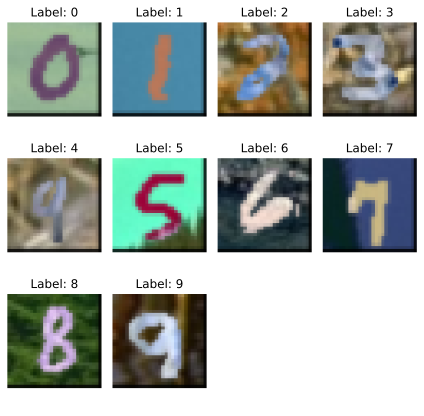

In [107]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import numpy as np

def plot_mnist_m_images(dataset):
    # Initialize a dictionary to hold one image for each label
    label_image_dict = {}

    # Create an instance of ToPILImage
    to_pil_image = ToPILImage()

    # Create a shuffled index list
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)

    # Loop through the dataset using the shuffled indices to find one image for each label
    for idx in indices:
        img_tensor, label = dataset[idx]
        if label not in label_image_dict:
            # Convert the tensor to a PIL image for plotting
            img = to_pil_image(img_tensor)
            label_image_dict[label] = img
        # Break the loop if we have found images for all 10 labels
        if len(label_image_dict) == 10:
            break

    fig, axes = plt.subplots(3, 4, figsize=(6, 6))  # Adjust for four rows and three columns
    fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust spacing between plots

    # Flatten the axes array and keep track of the current plot
    axes = axes.flatten()
    current_plot = 0

    for i, (label, img) in enumerate(sorted(label_image_dict.items())):
        ax = axes[current_plot]
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis('off')
        current_plot += 1

    # Hide any unused subplots
    for i in range(current_plot, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
# Replace 'raw_mnist_test' with your actual dataset variable
plot_mnist_m_images(raw_mnist_test)


Rotated Test Dataset

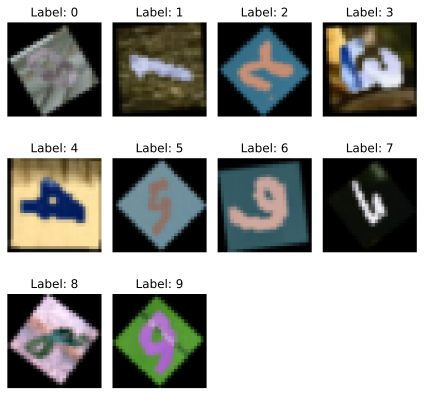

In [108]:
# Assuming `mnist_m_train` is your dataset instance
plot_mnist_m_images(mnist_m_test)

# Model : CNN and $SO(2)$ equivariant Steerable CNN

In [8]:
r2_act = gspaces.rot2dOnR2(N=-1)
G = r2_act.fibergroup

In [9]:
class CNN(torch.nn.Module):
    def __init__(self, img_size=29):  # Assuming the initial image size is 29x29
        super(CNN, self).__init__()
        
        self.conv_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # Output: (16, 29, 29)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2) # Output: (16, 14, 14)
        )
        
        self.conv_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3, 1, 1), # Output: (32, 14, 14)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2) # Output: (32, 7, 7)
        )
        
        self.conv_block3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, 1, 1), # Output: (64, 7, 7)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2) # Output: (64, 3, 3), adjusted due to size constraints
        )
        
        # Additional blocks start to include convolutional layers without pooling to prevent further reduction in feature map size too early.
        self.conv_block4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, 1, 1), # Output: (128, 3, 3)
            torch.nn.ReLU(),
            # No pooling layer
        )
        
        self.conv_block5 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, 3, 1, 1), # Output: (256, 3, 3)
            torch.nn.ReLU(),
            # No pooling layer
        )
        
        self.conv_block6 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, 3, 1, 1), # Output: (512, 3, 3)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2) # Output: (512, 1, 1), final pooling to reduce spatial dimensions.
        )

        # Fully connected layer, adjust according to the output of the last conv block
        self.out = torch.nn.Linear(512 * 1 * 1, 10)  # Assuming final feature map size is (512, 1, 1)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


In [10]:
class SO2SteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=10):

        super(SO2SteerableCNN, self).__init__()

        # the model is equivariant under all planar rotations
        self.r2_act = gspaces.rot2dOnR2(N=-1)

        # the group SO(2)
        self.G: SO2 = self.r2_act.fibergroup

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, 3*[self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # We need to mask the input image since the corners are moved outside the grid under rotations
        self.mask = nn.MaskModule(in_type, 29, margin=1)

        # convolution 1
        # first we build the non-linear layer, which also constructs the right feature type
        # we choose 8 feature fields, each transforming under the regular representation of SO(2) up to frequency 3
        # When taking the ELU non-linearity, we sample the feature fields on N=16 points
        activation1 = nn.FourierELU(self.r2_act, 8, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation1.in_type
        self.block1 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation1,
        )

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 16 regular feature fields
        activation2 = nn.FourierELU(self.r2_act, 16, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation2.in_type
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation2
        )
        # to reduce the downsampling artifacts, we use a Gaussian smoothing filter
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 32 regular feature fields
        activation3 = nn.FourierELU(self.r2_act, 32, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation3.in_type
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation3
        )

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 64 regular feature fields
        activation4 = nn.FourierELU(self.r2_act, 32, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation4.in_type
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation4
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields
        activation5 = nn.FourierELU(self.r2_act, 64, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation5.in_type
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation5
        )

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields
        activation6 = nn.FourierELU(self.r2_act, 64, irreps=G.bl_irreps(3), N=16, inplace=True)
        out_type = activation6.in_type
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.IIDBatchNorm2d(out_type),
            activation6
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)

        # number of output invariant channels
        c = 64

        # last 1x1 convolution layer, which maps the regular fields to c=64 invariant scalar fields
        # this is essential to provide *invariant* features in the final classification layer
        output_invariant_type = nn.FieldType(self.r2_act, c*[self.r2_act.trivial_repr])
        self.invariant_map = nn.R2Conv(out_type, output_invariant_type, kernel_size=1, bias=False)

        # Fully Connected classifier
        self.fully_net = torch.nn.Sequential(
            torch.nn.BatchNorm1d(c),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(c, n_classes),
        )

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = self.input_type(input)

        # mask out the corners of the input image
        x = self.mask(x)

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # Each layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)

        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)

        x = self.block5(x)
        x = self.block6(x)

        # pool over the spatial dimensions
        x = self.pool3(x)

        # extract invariant features
        x = self.invariant_map(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layer
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x

In [11]:
cnn = CNN().to(device)

In [12]:
scnn = SO2SteerableCNN().to(device) #instantiate the model

# Training the model

In [16]:
# build the training and test function

def test(model: torch.nn.Module):
    # test over the full rotated test set
    total = 0
    correct = 0

    with torch.no_grad():
        model.eval()
        for i, (x, t) in enumerate(test_loader):
            x = x.to(device)
            t = t.to(device)

            y = model(x)

            _, prediction = torch.max(y.data, 1)
            total += t.shape[0]
            correct += (prediction == t).sum().item()
    return correct/total*100.

def test_raw(model: torch.nn.Module):
    # test over the full rotated test set
    total = 0
    correct = 0

    with torch.no_grad():
        model.eval()
        for i, (x, t) in enumerate(raw_test_loader):
            x = x.to(device)
            t = t.to(device)

            y = model(x)

            _, prediction = torch.max(y.data, 1)
            total += t.shape[0]
            correct += (prediction == t).sum().item()
    return correct/total*100.

def train(model: torch.nn.Module, lr=1e-4, wd=1e-4, checkpoint_path: str = None):
    if checkpoint_path is not None:
        checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_path)

    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path))
        model.eval()
        return

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in tqdm(range(21)):
        model.train()
        for i, (x, t) in enumerate(train_loader):
            optimizer.zero_grad()

            x = x.to(device)
            t = t.to(device)

            y = model(x)

            loss = loss_function(y, t)

            loss.backward()

            optimizer.step()
            del x, y, t, loss

        if epoch % 10 == 0:
            accuracy = test(model)
            accuracy2 = test_raw(model)
            print(f"epoch {epoch} | test accuracy (Rotated): {accuracy : .2f} | test accuracy (Unrotated): {accuracy2 : .2f}")

    if checkpoint_path is not None:
        torch.save(model.state_dict(), checkpoint_path)

## Train the CNN model:

In [296]:
# set the seed manually for reproducibility
torch.manual_seed(42)
cnn = CNN().to(device)

#train(model, checkpoint_path="steerable_so2-pretrained.ckpt")
train(cnn)
accuracy = test(cnn)
print(f"Test accuracy (Rotated): {accuracy}")
accuracy2 = test_raw(cnn)
print(f"Test accuracy (Unrotated): {accuracy2}")
# Save the model state dictionary
cnn_path = "/home/seoyeon/project/cnn.pth"
torch.save(cnn.state_dict(), cnn_path)


  0%|          | 0/21 [00:00<?, ?it/s]

epoch 0 | test accuracy (Rotated):  19.32 | test accuracy (Unrotated):  72.01
epoch 10 | test accuracy (Rotated):  29.27 | test accuracy (Unrotated):  93.70
epoch 20 | test accuracy (Rotated):  31.25 | test accuracy (Unrotated):  94.94
Test accuracy (Rotated): 31.04
Test accuracy (Unrotated): 94.94


The accurcay for classifying rotated test dataset is significantly lowet that classifying unroteated test dataset.

## CNN: Confusion Matrix

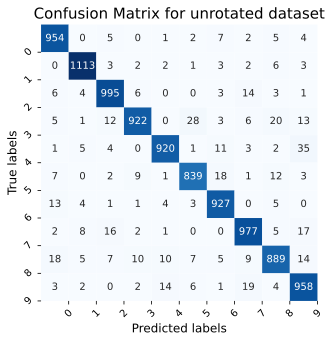

In [24]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn is optional for a nicer heatmap visualization

# Assuming 'test_loader' is your DataLoader for the test dataset
cnn_path = "/home/seoyeon/project/cnn.pth"
def get_all_preds(model, loader):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        model.eval()
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

# Load your model here
cnn.load_state_dict(torch.load(cnn_path))
# Make sure to switch your model to evaluation mode
cnn.eval()
# Get all predictions and true labels
predictions, true_labels = get_all_preds(cnn, raw_test_loader)
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the size as needed
sns.heatmap(cm, annot=True, ax=ax, square=True, cmap='Blues', fmt='g', cbar=False)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Labels, title, and ticks
label_font = {'size':'12'}  # Adjust the size as needed
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Confusion Matrix for unrotated dataset', fontdict={'size':'15'})  # Adjust the size as needed
tick_marks = np.arange(len(classes)) + 0.5
plt.xticks(tick_marks + 0.5, classes, rotation=45)
plt.yticks(tick_marks + 0.5, classes, rotation=45)
plt.show()


CNN performs well at classifying unrotated datasets.

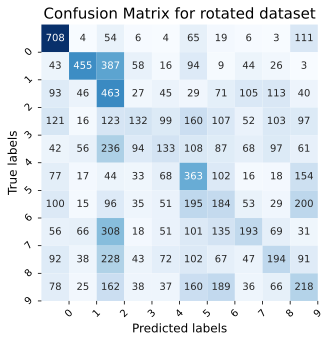

In [23]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn is optional for a nicer heatmap visualization

# Assuming 'test_loader' is your DataLoader for the test dataset

def get_all_preds(model, loader):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        model.eval()
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

# Load your model here
cnn.load_state_dict(torch.load(cnn_path))
# Make sure to switch your model to evaluation mode
cnn.eval()
# Get all predictions and true labels
predictions, true_labels = get_all_preds(cnn, test_loader)
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the size as needed
sns.heatmap(cm, annot=True, ax=ax, square=True, cmap='Blues', fmt='g', cbar=False)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Labels, title, and ticks
label_font = {'size':'12'}  # Adjust the size as needed
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Confusion Matrix for rotated dataset', fontdict={'size':'15'})  # Adjust the size as needed
tick_marks = np.arange(len(classes)) + 0.5
plt.xticks(tick_marks + 0.5, classes, rotation=45)
plt.yticks(tick_marks + 0.5, classes, rotation=45)
plt.show()


CNN didn't classify rotated test dataset well. It proves that CNN is hard to capture rotational equivariance.

## Train the $SO(2)$ equivariant model:

In [31]:
# set the seed manually for reproducibility
torch.manual_seed(42)
scnn = SO2SteerableCNN().to(device)

#train(model, checkpoint_path="steerable_so2-pretrained.ckpt")
train(scnn)
accuracy = test(scnn)
print(f"Test accuracy (Rotated): {accuracy}")
accuracy2 = test_raw(scnn)
print(f"Test accuracy (Unrotated): {accuracy2}")
# Save the model state dictionary
scnn_path = "/home/seoyeon/project/scnn.pth"
torch.save(scnn.state_dict(), scnn_path)


  0%|          | 0/21 [00:00<?, ?it/s]

epoch 0 | test accuracy (Rotated):  54.41 | test accuracy (Unrotated):  82.24
epoch 10 | test accuracy (Rotated):  65.86 | test accuracy (Unrotated):  93.58
epoch 20 | test accuracy (Rotated):  67.58 | test accuracy (Unrotated):  95.48
Test accuracy (Rotated): 67.52
Test accuracy (Unrotated): 95.48


Steerable CNN achieves more than twice the accuracy of standard CNN when classifying rotated test datasets. 67.54% vs 31.04%

## Steerable CNN: Confusion Matrix

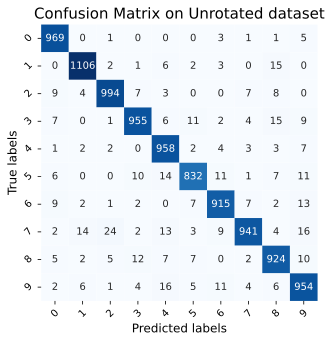

In [21]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn is optional for a nicer heatmap visualization

# Assuming 'test_loader' is your DataLoader for the test dataset
scnn_path = "/home/seoyeon/project/scnn.pth"
def get_all_preds(model, loader):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        model.eval()
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)
# Load your model here
scnn.load_state_dict(torch.load(scnn_path))
# Make sure to switch your model to evaluation mode
scnn.eval()

# Get all predictions and true labels
predictions, true_labels = get_all_preds(scnn, raw_test_loader)
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the size as needed
sns.heatmap(cm, annot=True, ax=ax, square=True, cmap='Blues', fmt='g', cbar=False)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Labels, title, and ticks
label_font = {'size':'12'}  # Adjust the size as needed
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Confusion Matrix on Unrotated dataset', fontdict={'size':'15'})  # Adjust the size as needed
tick_marks = np.arange(len(classes)) + 0.5
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes, rotation=45)
plt.show()


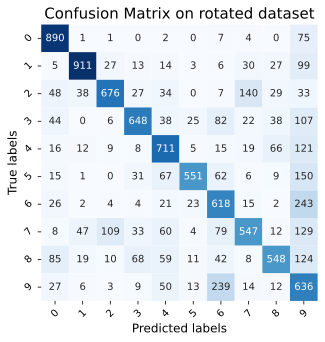

In [22]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn is optional for a nicer heatmap visualization

# Assuming 'test_loader' is your DataLoader for the test dataset

def get_all_preds(model, loader):
    all_preds = []
    all_targets = []
    with torch.no_grad():
        model.eval()
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)
# Load your model here
scnn.load_state_dict(torch.load(scnn_path))
# Make sure to switch your model to evaluation mode
scnn.eval()

# Get all predictions and true labels
predictions, true_labels = get_all_preds(scnn, test_loader)
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the size as needed
sns.heatmap(cm, annot=True, ax=ax, square=True, cmap='Blues', fmt='g', cbar=False)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Labels, title, and ticks
label_font = {'size':'12'}  # Adjust the size as needed
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Confusion Matrix on rotated dataset', fontdict={'size':'15'})  # Adjust the size as needed
tick_marks = np.arange(len(classes)) + 0.5
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes, rotation=45)
plt.show()


# Test the model

Evaluate the `model` on 16 rotated versions of the first 10000 images in the test set

In [35]:
from torchvision.transforms.functional import to_pil_image
def test_model_rotations(model: torch.nn.Module, N: int = 24, M: int = 2000, checkpoint_path: str = None):
    # evaluate the `model` on N rotated versions of the first M images in the test set

    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        accuracies = np.load(checkpoint_path)
        return accuracies.tolist()

    model.eval()
    model.to(device)
    # to reduce interpolation artifacts (e.g. when testing the model on rotated images),
    # we upsample an image by a factor of 3, rotate it and finally downsample it again
    resize1 = Resize(87) # to upsample
    resize2 = Resize(29) # to downsample

    totensor = ToTensor()

    accuracies = []
    with torch.no_grad():
        model.eval()

        for r in tqdm(range(N)):
            total = 0
            correct = 0

            for i in range(M):
                x, t = raw_mnist_test[i]

                #x = Image.fromarray(x.numpy()[0], mode='RGB')
                x = to_pil_image(x)
                x = totensor(resize2(resize1(x).rotate(r*360./N, Image.BILINEAR))).unsqueeze(0).to(device)
                import matplotlib.pyplot as plt

                # Assuming `x` is the processed image tensor and still in the device
                # Make sure to detach `x` from the current graph if it requires grad
                #x = x.detach()

                # If `x` is on a GPU, move it to CPU. Then convert it to a NumPy array
                #x_np = x.squeeze().cpu().numpy()  # Remove the batch dimension with `squeeze()` if present

                # If the image is RGB, transpose the array to [H, W, C] for plotting
                #if x_np.shape[0] == 3:  # Check if there are 3 channels
                #    x_np = x_np.transpose(1, 2, 0)

                # Plot the image
                #plt.imshow(x_np)
                #plt.axis('off')  # Optionally remove the axes for better visualization
                #plt.show()

                x = x.to(device)
                t = torch.tensor([t], dtype=torch.long, device=device)
                y = model(x)

                _, prediction = torch.max(y, 1)
                total += 1
                correct += (prediction == t).sum().item()

            accuracies.append(correct/total*100.)

    if checkpoint_path is not None:
        np.save(checkpoint_path, np.array(accuracies))

    return accuracies

In [36]:
accs_cnn = test_model_rotations(cnn, 16, 10000, checkpoint_path = "/home/seoyeon/project/cnn-accuracies.npy")

accs_so2 = test_model_rotations(scnn, 16, 10000, checkpoint_path = "/home/seoyeon/project/scnn-accuracies.npy")


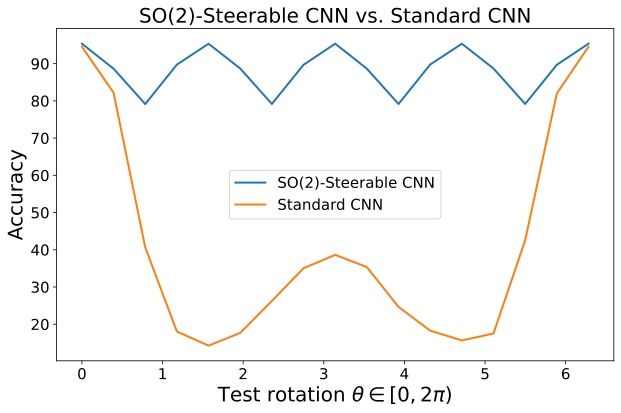

In [37]:
# plot the accuracy of as a function of the rotation angle theta applied to the test set
fig, ax = plt.subplots(figsize=(10, 6))

N = 16

xs = [i*2*np.pi / N for i in range(N+1)]
plt.plot(xs, accs_so2 + [accs_so2[0]],  label='SO(2)-Steerable CNN')
plt.plot(xs, accs_cnn + [accs_cnn[0]], label='Standard CNN')
plt.title('SO(2)-Steerable CNN vs. Standard CNN', fontsize=20)
plt.xlabel(r'Test rotation $\theta \in [0, 2\pi)$', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=15)
plt.show()

Even though the steerable CNN does not achieve perfect \(SO(2)\) equivariance after training, it exhibits significantly more stability to rotations in its accuracy compared to standard CNNs.